# Age Detection Model

**Import necessary libraries**

In [21]:
import os                  
import cv2                 
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm

import matplotlib.pyplot as plt
import random 


**Load the dataset**

In [8]:
image_data='/kaggle/input/utk-face-cropped/utkcropped'    
image_size = 224            # We resize all images to 224x224 for our MobileNetV2 Model
X,y=[],[]

files = os.listdir(image_data)[:5000] #Work on the 5000 becasue the system is not handle the overall dataset

for file in tqdm(files):
    try:
        age = int(file.split("_")[0])  # Extract the  age via filename
        img_path = os.path.join(image_data, file)
        
        image = cv2.imread(img_path)
        image = cv2.resize(image, (image_size, image_size))
        image = image / 255.0  # Normalize the images

        X.append(image)
        y.append(age)
    except:
        continue

X = np.array(X)
y = np.array(y)

print("Total images loaded:-", len(X))
print("shape of X:-", X.shape)
print("Shape of y:-", y.shape)

100%|██████████| 5000/5000 [00:52<00:00, 95.72it/s] 


Total images loaded:- 5000
shape of X:- (5000, 224, 224, 3)
Shape of y:- (5000,)


**Split the data for training and testing**

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
#print the quantity of training and testing data
print(f"Training data for Model:- {len(X_train)}")
print(f"Testing data for Model:- {len(X_test)}")

Training data for Model:- 4000
Testing data for Model:- 1000


**Build the MobileNetV2-Based Model**

In [10]:
#Define the shape for input
input_shape=(224,224,3)

## Load pre-trained MobileNetV2 model without the top layer to make our own layer
base_model=MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
    )

#Stop the base model layer
base_model.trainable=False

# create the new model on first of base
inputs=Input(shape=input_shape)
x=base_model(inputs,training=False)
x=GlobalAveragePooling2D()(x)
x=Dropout(0.3)(x)
x=Dense(128,activation='relu')(x)
x=Dropout(0.3)(x)

output=Dense(1)(x) #One output neuraon for predicting the age

#Bulid the proper Model
model=Model(inputs,output)

#compile the model using the MSL(mean square loss) which is part of regression
model.compile(optimizer='adam',
             loss='mean_squared_error',
             metrics=['mae'])
#Mean absolute Error to creating our model more readable
print("done")

I0000 00:00:1751978254.205709      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751978254.206338      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
done


**Training the model**

In [11]:
#set the Training Callbacks for better training
checkpoint=ModelCheckpoint('age_model.h5',      # Save better accuracy model to this .h5 file
                          monitor='val_loss',   # Checking the validation loss to save model
                          save_best_only=True,
                          verbose=1)

earlystops=EarlyStopping(monitor='val_loss',        # Stop if validation loss stops improving
                        patience=5,                 # Wait for 5 epochs before stopping
                        restore_best_weights=True)  # Roll back to best weights
print("done")

done


In [15]:
history=model.fit(X_train,y_train,
                 validation_data=(X_test,y_test),
                 epochs=15,
                 batch_size=16,                      # there is number of samples per step
                 callbacks=[checkpoint, earlystops])  # checkpoint improve training with callbacks

print("done")

Epoch 1/15
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 156.4402 - mae: 9.4673
Epoch 1: val_loss did not improve from 172.71072
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 156.4588 - mae: 9.4687 - val_loss: 174.8926 - val_mae: 9.6464
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 155.4291 - mae: 9.3893
Epoch 2: val_loss did not improve from 172.71072
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 155.4347 - mae: 9.3896 - val_loss: 179.2019 - val_mae: 9.5830
Epoch 3/15
247/250 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 151.2338 - mae: 9.4149
Epoch 3: val_loss improved from 172.71072 to 172.34386, saving model to age_model.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 151.2401 - mae: 9.4143 - val_loss: 172.3439 - val_mae: 9.4919
Epoch 4/15
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 144.9738 - mae: 9.1303
Epoch 4: val_loss did not improve from 172.34386
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 145.0077 - mae: 9.1313 - val_loss: 173.2298 - 

In [18]:
val_mae_list = history.history['val_mae'] #Get the Mean Absolute error for accuracy

best_val_mae = min(val_mae_list)# take minimum val_mae


max_age = 116   # (enter the  dataset max age is 116/100)

# Calculate the Accuracy
accuracy = (1 - (best_val_mae / max_age)) * 100

print(f"Best Validation MAE: {best_val_mae:.2f}")
print(f"Estimated Accuracy: {accuracy:.2f}%")


Best Validation MAE: 9.25
Estimated Accuracy: 92.02%


**Testing Our Model Prediction**

In [16]:
y_pred=model.predict(X_test) #predict the age using our trained model
y_pred=y_pred.flatten() #Converting into the 1D array

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


**Visualize Actual vs Predicted Age (10 Random Samples)**

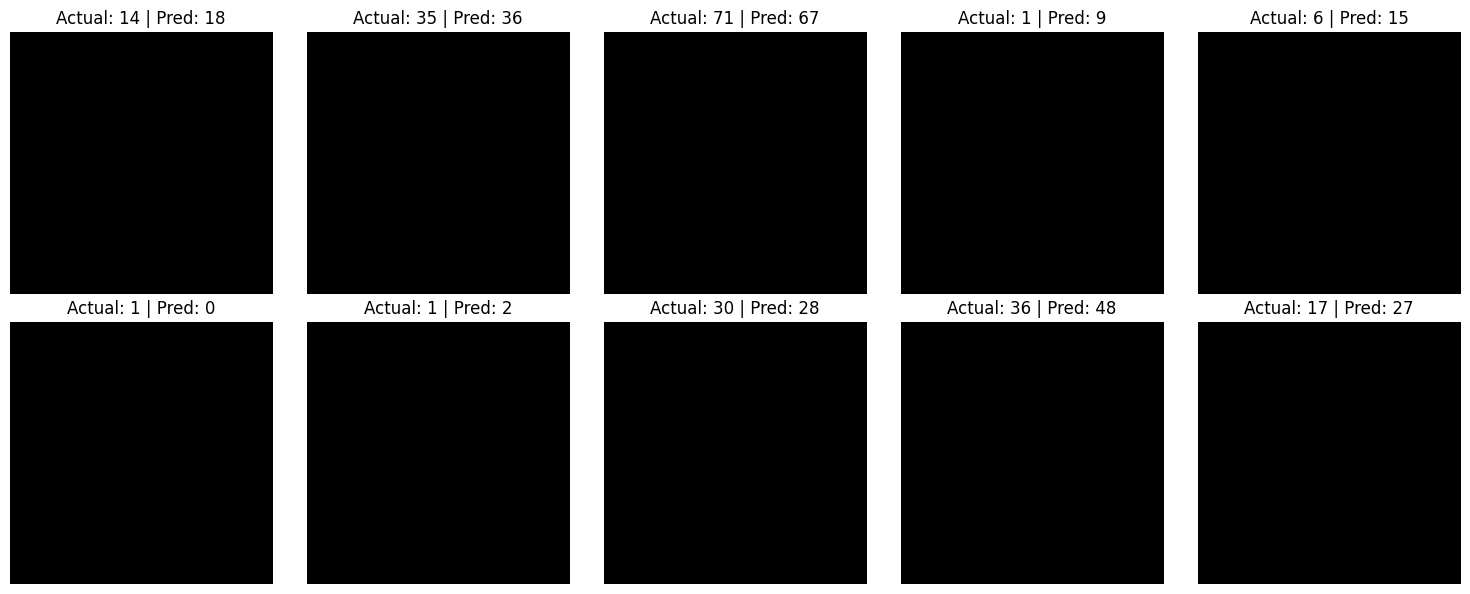

In [22]:
plt.figure(figsize=(15,6))
for i in range(10):
    index = random.randint(0, len(X_test) - 1)  # random index from test data 
    image = X_test[index]
    true_age = int(y_test[index])
    predicted_age = int(y_pred[index])

    plt.subplot(2, 5, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f"Actual: {true_age} | Pred: {predicted_age}")
    plt.axis('off')

plt.tight_layout()
plt.show()